In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np


In [2]:
# Data cleaning
def extract_data(data: pd.DataFrame) -> pd.DataFrame:
    # Name cleanup to get features of Title, Forename and Lastname
    data[["LastNm", "Name"]] = data["Name"].str.split(",", expand=True)
    data[["Title", "ForeNm"]] = data["Name"].str.split(
        ". ", n=1, expand=True, regex=False
    )
    data = data.drop(["Name"], axis=1)
    data["Sex"] = data["Sex"].astype("category").cat.codes

    obj_col = data.select_dtypes(["object"])
    data[obj_col.columns] = obj_col.apply(lambda x: x.str.strip())

    data["Rooms"] = (
        data["Cabin"]
        .fillna("Steerage")
        .str.split(" ", expand=False)
        .map(lambda x: 0 if x == ["Steerage"] else len(x))
    )

    data["Floor"] = data["Cabin"].fillna("Steerage").str[:1]

    data = data.drop(columns=["Ticket", "ForeNm", "LastNm", "PassengerId", "Cabin"])

    for c in data.columns:
        data[c] = data[c].fillna(data[c].mode()[0])

    return data


In [3]:
# Inputs
def standardize_inputs(df: pd.DataFrame) -> dict:
    inputs = {}
    for name, column in df.items():
        if type(column[0]) == str:
            dtype = tf.string
        elif name in categorical_features_names or name in binary_features_names:
            dtype = tf.int64
        elif name in numeric_features_names:
            dtype = tf.float32
        else:
            continue
        inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)

    return inputs


In [4]:
# Preprocessor
def create_preprocessor(
    inputs: dict,
    categorical_features_names: list,
    numeric_features_names: list,
    binary_features_names: list,
) -> tf.keras.Model():

    # Initialise the list of preprocessed values
    preprocessed = []

    # Binary
    for name in binary_features_names:
        inp = inputs[name]
        inp = inp[:, tf.newaxis]
        float_value = tf.cast(inp, tf.float32)
        preprocessed.append(float_value)

    # Numeric
    def stack_dict(inputs, fun=tf.stack):
        values = []
        for key in sorted(inputs.keys()):
            values.append(tf.cast(inputs[key], tf.float32))

        return fun(values, axis=-1)

    numeric_features = df[numeric_features_names]

    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(stack_dict(dict(numeric_features)))

    numeric_inputs = {}
    for name in numeric_features:
        numeric_inputs[name] = inputs[name]

    numeric_inputs = stack_dict(numeric_inputs)
    numeric_normalized = normalizer(numeric_inputs)

    preprocessed.append(numeric_normalized)

    # Categorical
    for name in categorical_features_names:
        vocab = sorted(set(df[name].dropna().values))

        if type(vocab[0]) is str:
            lookup = tf.keras.layers.StringLookup(
                vocabulary=vocab, output_mode="one_hot"
            )
        else:
            lookup = tf.keras.layers.IntegerLookup(
                vocabulary=vocab, output_mode="one_hot"
            )

        x = inputs[name][:, tf.newaxis]
        x = lookup(x)
        preprocessed.append(x)

    preprocesssed_result = tf.concat(preprocessed, axis=-1)
    return tf.keras.Model(inputs, preprocesssed_result)


In [5]:
# Fetch the data
df = extract_data(pd.read_csv("train.csv"))


In [6]:
# Build Training, validation, and testing sets features & labels
LABEL = "Survived"
target = df.pop(LABEL).to_numpy(dtype=np.int64)


In [7]:
# Create the preprocessor
categorical_features_names = ["Embarked", "Title", "Floor", "Pclass"]
numeric_features_names = ["SibSp", "Age", "Parch", "Fare", "Rooms"]
binary_features_names = ["Sex"]
inputs = standardize_inputs(df)
preprocessor = create_preprocessor(
    inputs=inputs,
    categorical_features_names=categorical_features_names,
    numeric_features_names=numeric_features_names,
    binary_features_names=binary_features_names,
)


2022-04-02 19:08:20.772594: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


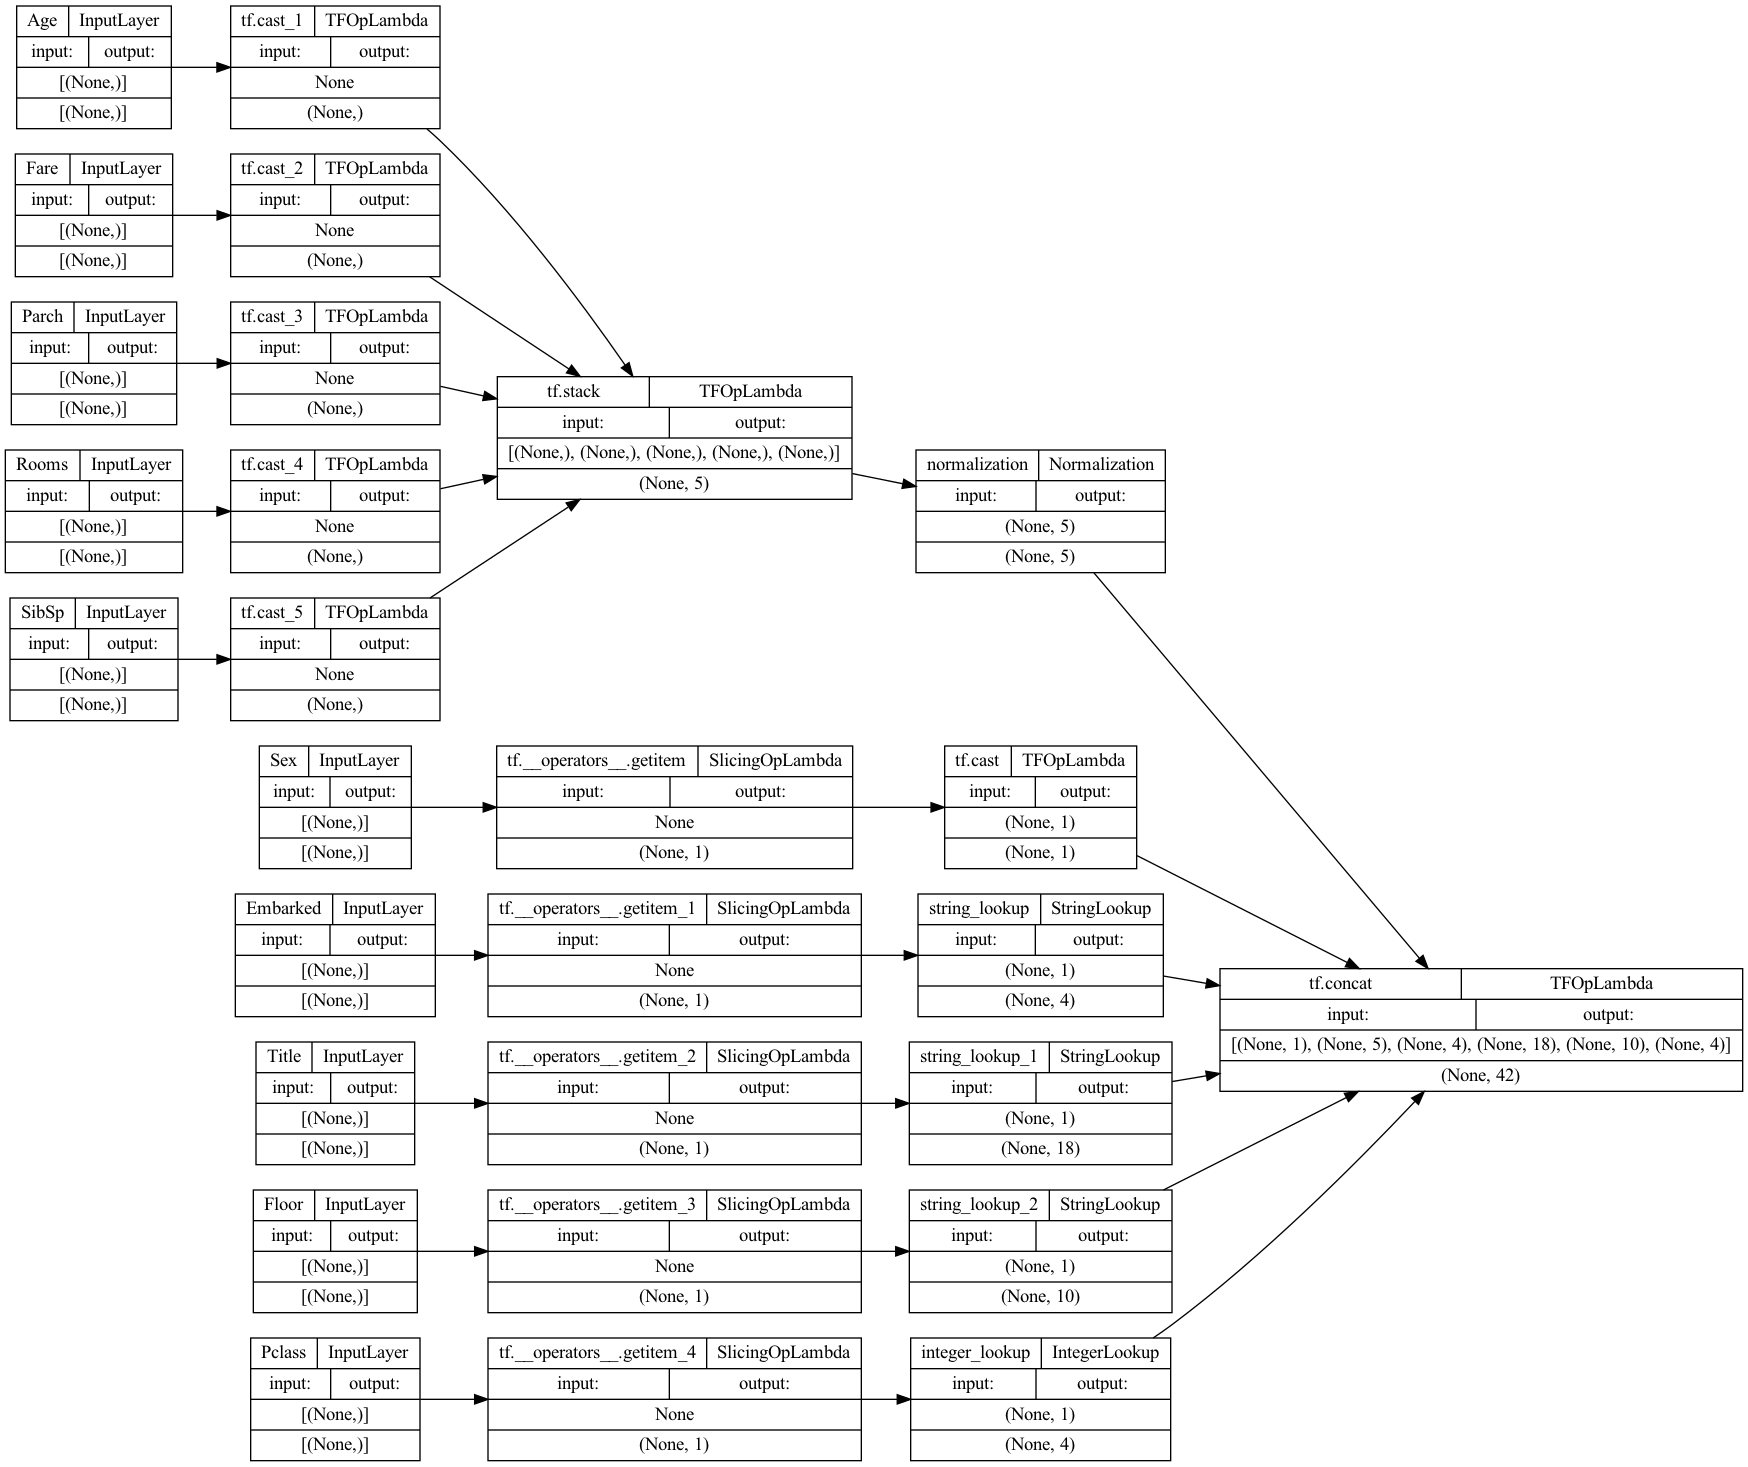

In [8]:
# Plot the preprocessor
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)


In [9]:
def run_model(inputs, preprocessor, sequential, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT):
    x = preprocessor(inputs)
    result = sequential(x)
    model = tf.keras.Model(inputs, result)

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"],
    )

    history = model.fit(
        dict(df),
        target,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        verbose=0,
    )

    return model, history


In [10]:
def plot_history(history):
    import matplotlib.pyplot as pyp

    pyp.style.use("seaborn")
    fig, ax = pyp.subplots(1, 2, figsize=(10, 4))

    ax[0].set_title(f"accuracy for {history.model.name}", color="C0")
    ax[1].set_title(f"loss for {history.model.name}", color="C0")

    ax[0].plot(history.history["accuracy"], color="tab:blue", label="Train Accuracy")
    ax[0].plot(
        history.history["val_accuracy"], color="tab:orange", label="Val Accuracy"
    )
    ax[1].plot(
        history.history["loss"],
        color="tab:blue",
        linestyle="dotted",
        label="Train Loss",
    )
    ax[1].plot(
        history.history["val_loss"],
        color="tab:orange",
        linestyle="dotted",
        label="Val Loss",
    )
    ax[0].legend(loc="lower right")
    ax[1].legend(loc="upper right")


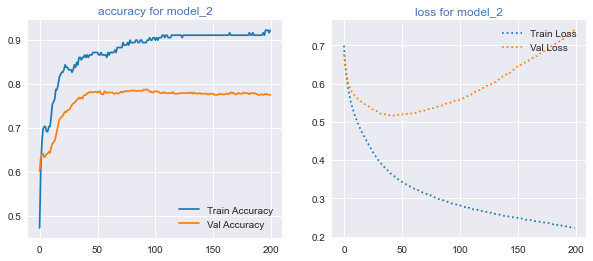

In [11]:
# Model 1
EPOCHS = 200
BATCH_SIZE = 20
VALIDATION_SPLIT = 0.8

sequential1 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model1, history1 = run_model(
    inputs, preprocessor, sequential1, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT
)
plot_history(history1)


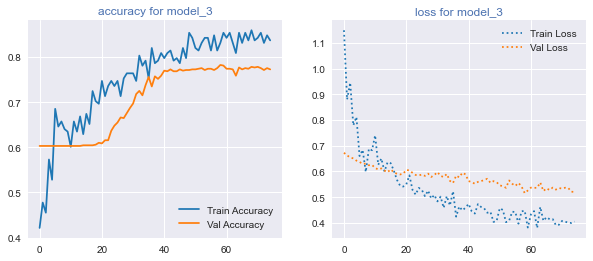

In [12]:
# Model 2
EPOCHS = 75
BATCH_SIZE = 20
VALIDATION_SPLIT = 0.8

sequential2 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.GaussianNoise(1, seed=77),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.GaussianNoise(1, seed=77),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.GaussianNoise(1, seed=77),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model2, history2 = run_model(
    inputs, preprocessor, sequential2, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT
)
plot_history(history2)


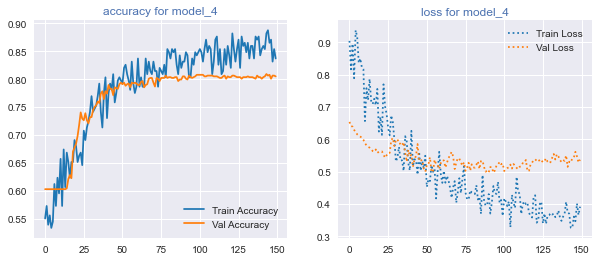

In [13]:
# Model 3
EPOCHS = 150
BATCH_SIZE = 25
VALIDATION_SPLIT = 0.8

sequential3 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.GaussianNoise(1, seed=77),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.GaussianNoise(1, seed=77),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.GaussianNoise(1, seed=77),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model3, history3 = run_model(
    inputs, preprocessor, sequential3, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT
)
plot_history(history3)


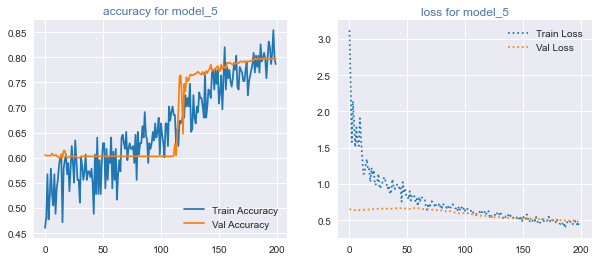

In [14]:
# Model 4
EPOCHS = 200
BATCH_SIZE = 25
VALIDATION_SPLIT = 0.8

sequential4 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.GaussianNoise(5, seed=77),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.GaussianNoise(4, seed=77),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.GaussianNoise(3, seed=77),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.GaussianNoise(2, seed=77),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model4, history4 = run_model(
    inputs, preprocessor, sequential4, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT
)
plot_history(history4)


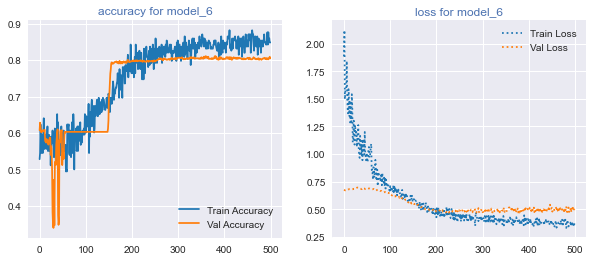

In [15]:
# Model 5
EPOCHS = 500
BATCH_SIZE = 25
VALIDATION_SPLIT = 0.8

sequential5 = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.GaussianNoise(5, seed=77),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.GaussianNoise(4, seed=77),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.GaussianNoise(3, seed=77),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.GaussianNoise(2, seed=77),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model5, history5 = run_model(
    inputs, preprocessor, sequential5, EPOCHS, BATCH_SIZE, VALIDATION_SPLIT
)
plot_history(history5)


In [16]:
# Generate predictions
predict_df = extract_data(pd.read_csv("test.csv"))
predict_array = standardize_inputs(predict_df)


In [17]:
predictions = (model5.predict(dict(predict_df)) > 0.5).astype(int).ravel()


In [18]:
submit = pd.DataFrame(
    {"PassengerId": pd.read_csv("test.csv")["PassengerId"], "Survived": predictions}
)


In [19]:
submit["Survived"].value_counts()


0    269
1    149
Name: Survived, dtype: int64

In [20]:
submit


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [21]:
submit.to_csv("titanic_submission.csv", index=False)
